In [110]:
#### FOR STAGE DATA 

import matplotlib.pyplot as plt
import ast
import re
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.patches as patches
from itertools import chain


frames = []
calcs = []
threshold_ps = [25,25,25,28,28,28,32,32,32]
file_index = "0081"
bs_ps = 10
#dev = [4,8,12,4,8,12,4,8,12]
dev = [4,6,8,4,6,8,4,6,8]
offset = 45.9    # correct position data

file_name = f"../merge/merge_data/merge_data_{file_index}.txt"

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
fs = 12

def modify_data(data, expected_length=1):

    # for stage data 
    data = ast.literal_eval(data)

    converted_data = []
    for outer in data:
        temp = [outer[0]]  # Keep the first element as it is (already a float)
        try:
            temp.extend(float(inner) for inner in outer[1])  # Convert inner list elements to float and extend the temp list
        except ValueError:
            continue
        converted_data.append(temp)

    # check for invalid entries
    valid_data = []
    invalid_entries = []
    for i, entry in enumerate(converted_data):
        if len(entry) == 9:
            # Check if all elements can be converted to float
            try:
                temp = [float(entry[0])] + [float(x) for x in entry[1:]]
                valid_data.append(temp)
            except ValueError:
                invalid_entries.append(i)
        else:
            invalid_entries.append(i)

    data = valid_data[100:len(valid_data)]
    valid_data = list(map(list, zip(*data)))
    return valid_data

def find_min_max_y(serial_data):
    y_max = []
    y_min = []

    max, _ = find_peaks(serial_data, prominence=5, distance=1000)
    min, _ = find_peaks(-np.array(serial_data), prominence = 5, distance=650)

    for i in range(len(max)):
        y_max.append(serial_data[max[i]])

    for i in range(len(min)):
        y_min.append(serial_data[min[i]])
    
    return min, max, y_min, y_max

def deviation(dev):
    dev_list = []
    for i in range(bs_ps-1):
        dev_list.append(0)

    for i in range(bs_ps, len(dev)+1): 
        temp = []
        for j in range(bs_ps):
            temp.append(dev[(i-bs_ps)+j])
        dev_list.append(temp)

    return dev_list

def sum_reed(data_transposed):
    f0 = data_transposed[5]
    f1 = data_transposed[6]
    b0 = data_transposed[7]
    b1 = data_transposed[8]
    reed_sum = []
    
    for i in range(len(f0)):
        reed_sum.append(f0[i]+f1[i]+b0[i]+b1[i])
 
    return reed_sum

def determine_laser_state_dev_ps(dev_list,dev_size):
    laser_state_dev = []
    for i in range(bs_ps-1):
        laser_state_dev.append(0)

    dev_list = dev_list[bs_ps-1:len(dev_list)]
    
    for row in dev_list:
        if all(-(dev_size) <= value <= dev_size for value in row):
            laser_state_dev.append(1)
        else:
            laser_state_dev.append(0)

    return laser_state_dev

def determine_laser_pt(laser_state_dev, average, threshold_ps):
    laser_state = []

    for i in range(len(average)):
        if ((average[i] < threshold_ps) and (laser_state_dev[i] == 1)):
            laser_state.append(1)
        else:   
            laser_state.append(0)

    return laser_state 

def determine_laser_reed(reed_sum):

    laser_state_reed = []
    for i in range(len(reed_sum)):
        if reed_sum[i] == 4:
            laser_state_reed.append(1)
        else:
            laser_state_reed.append(0)
    return laser_state_reed

def find_laser_rect(laser_state,index):
    start_on = [index[i] for i in range(1, len(laser_state)) if laser_state[i] == 1 and laser_state[i-1] == 0]
    end_on = [index[i] for i in range(1, len(laser_state)) if laser_state[i] == 0 and laser_state[i-1] == 1]

    if (start_on[0] > end_on[0]):
        start_on = [0] + start_on

    if len(start_on) != len(end_on):
        end_on.append(len(laser_state))

    return start_on, end_on

def resulting_laser_state(state_pt, state_reed):
    res_state = []

    for i in range(len(state_pt)):
        if all([state_pt[i], state_reed[i]]):
            res_state.append(1)
        else:
            res_state.append(0)
    return res_state

def find_batches(x, stage):
    pos = []

    in_batch = False
    for i in range(len(x)):
        if x[i] == 1 and not in_batch:
            pos.append(i)
            in_batch = True
        elif x[i] == 0 and in_batch:
            pos.append(i - 1)
            in_batch = False
    if in_batch:
        pos.append(len(x) - 1)

    x_list = [-30]          # für steps
    for i in pos:
       x_list.append(stage[i])  
    x_list.append(4)        # für steps

    return x_list

with open(file_name, "r") as file:
    serial_data = file.read()

for i in range(len(dev)):
    data_transposed = modify_data(serial_data)
    data_transposed[0]  =  list((np.array(data_transposed[0]) - offset))  #

    index =  [i for i in range(len(data_transposed[0]))]

    ### PT THINGS
    dev_list = deviation(data_transposed[4])
    laser_state_dev = determine_laser_state_dev_ps(dev_list, dev[i])          # dev übergeben
    laser_state_pt = determine_laser_pt(laser_state_dev, data_transposed[3], threshold_ps[i])     # avg übergeben

    ### REED THINGS
    reed_sum = sum_reed(data_transposed)
    laser_state_reed = determine_laser_reed(reed_sum)

    ### ALL
    laser_state_result = resulting_laser_state(laser_state_pt, laser_state_reed)

    data_all = {'index':index,
                'position': data_transposed[0],
                'acc_vec':  data_transposed[1],
                'pt_raw': data_transposed[2],
                'pt_avg': data_transposed[3],
                'pt_dev': data_transposed[4],
                'reedf0': data_transposed[5],
                'reedf1': data_transposed[6],
                'reedb0': data_transposed[7],
                'reedb1': data_transposed[8],
                'reed_sum': reed_sum,
                'laser_pt': laser_state_pt,
                'laser_reed': laser_state_reed,
                'laser_result': laser_state_result}

    pd_all = pd.DataFrame(data = data_all)   

    x_acc_pt = find_batches(list(pd_all.laser_pt),list(pd_all.position))
    x_acc_reed = find_batches(list(pd_all.laser_reed),list(pd_all.position))
    x_acc_pt.sort()
    x_acc_reed.sort()

    # mean without additional values for step
    mean_pt = round(np.mean(x_acc_pt[1:len(x_acc_pt)-1]),2)
    mean_reed = round(np.mean(x_acc_reed[1:len(x_acc_reed)-1]),2)
    std_pt = round(np.std(x_acc_pt[1:len(x_acc_pt)-1]), 2)
    std_reed = round(np.std(x_acc_reed[1:len(x_acc_reed)-1]), 2)

    frames.append([file_index, pd_all, x_acc_pt, x_acc_reed, mean_pt, mean_reed, std_pt, std_reed])

# [file_index, pd_all, x_acc_pt, x_acc_reed, mean_pt, mean_reed, std_pt, std_reed]


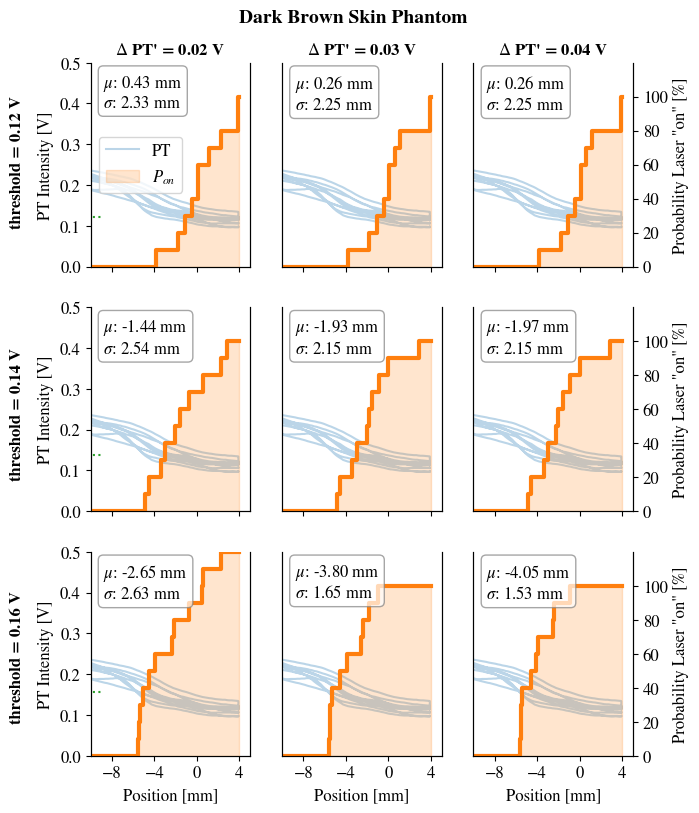

In [122]:

fig, axs = plt.subplots(3,3, figsize=(7,9))
axs_twin = [[axs.twinx() for axs in row] for row in axs]
axs_twin_flat = [axs for row in axs_twin for axs in row]

def raw_to_voltage(raw):
    return raw * (5.0 / 1023)

def make_text():
    fig.text(0.5, 0.93, f'Dark Brown Skin Phantom', va='center', ha='center', rotation='horizontal', fontsize=14, weight='bold')

    axs[0,0].set_title(f'$\Delta$ PT\' = {round(dev[0]*(5/1023),2)} V', weight='bold', fontsize=fs)
    axs[0,1].set_title(f'$\Delta$ PT\' = {round(dev[1]*(5/1023),2)} V', weight='bold', fontsize=fs)
    axs[0,2].set_title(f'$\Delta$ PT\' = {round(dev[2]*(5/1023),2)} V', weight='bold', fontsize=fs)

    fig.text(0.02, 0.77, f'threshold = {round(threshold_ps[0]*(5/1023),2)} V', va='center', ha='center', rotation='vertical', fontsize=fs, weight='bold')
    fig.text(0.02, 0.49, f'threshold = {round(threshold_ps[3]*(5/1023),2)} V', va='center', ha='center', rotation='vertical', fontsize=fs, weight='bold')
    fig.text(0.02, 0.22, f'threshold = {round(threshold_ps[6]*(5/1023),2)} V', va='center', ha='center', rotation='vertical', fontsize=fs, weight='bold')

    axs[0,0].set(ylabel='PT Intensity [V]')
    axs[1,0].set(ylabel='PT Intensity [V]')
    axs[2,0].set(ylabel='PT Intensity [V]',xlabel='Position [mm]')
    axs[2,1].set(xlabel='Position [mm]')
    axs[2,2].set(xlabel='Position [mm]')

    axs[0,1].set_yticklabels([])        
    axs[1,1].set_yticklabels([])
    axs[2,1].set_yticklabels([])    
    axs[0,2].set_yticklabels([])
    axs[1,2].set_yticklabels([])
    axs[2,2].set_yticklabels([])

    axs[0,0].step([],[], color = 'C0', alpha = 0.3, label = "PT")
    axs[0,0].fill_between([],[], color = 'C1', alpha = 0.2, label = "$P_{on}$")
    axs[0,0].legend(loc = "center left")


for i, ax in enumerate(axs.flatten()):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_position(('data', 5))
    ax.spines['bottom'].set_position(('data', 0))

    ylim = 102
    ax.set_ylim(0, ylim)
    raw_ticks = np.linspace(0, ylim, 6)  # 11 ticks from 0 to 1023
    voltage_ticks = raw_to_voltage(raw_ticks)
    ax.set_yticks(raw_ticks)
    ax.set_yticklabels([f'{tick:.1f}' for tick in voltage_ticks])

    ax.set_xlim([-10,5])
    ax.set_xticks([-8,-4,0,4])

    if i in [0,3,6]:
        ax.hlines(y=threshold_ps[i], xmin=-50, xmax=-9, color='C2', ls=':')

    ax.plot(pd_all.position, pd_all.pt_avg, color = 'C0', alpha = 0.3)

    if i in [0,1,2,3,4,5]:
        ax.set_xticklabels([])
   
    if i in [1,2,4,5,7,8]:
        ax.tick_params(left = False)

for i, ax2 in enumerate(axs_twin_flat):

    # ax2.set_ylim([0,11])
    ax2.spines['top'].set_visible(False)

    ax2.set_ylim(0, 12)
    raw_ticks = np.linspace(0, 10, 6)  # 11 ticks from 0 to 1023
    ax2.set_yticks(raw_ticks)
    ax2.set_yticklabels([f'{int(tick*10)}' for tick in raw_ticks])

    props = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='grey')    
    textstr = '\n'.join((
            r'$\mu$: %.2f mm' % (frames[i][4],),
            r'$\sigma$: %.2f mm' % (frames[i][6], )))    
    ax2.text(0.08, 0.95, textstr, transform=ax2.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)

    y_pt = [i-1 for i in range(len(frames[i][2]))]
    ax2.step(frames[i][2],y_pt, linewidth = 3, where = 'pre', color = 'C1')
    ax2.fill_between(frames[i][2],y_pt, step="pre", color = 'C1', alpha=0.2)    

    if i in [2,5,8]:
        ax2.set(ylabel='Probability Laser "on" [%]')
    else:
        ax2.set_yticklabels([])

    if i in [0,1,3,4,6,7]:
        ax2.tick_params(right = False)

make_text()

# name_file = f"PT_compare_threshold_and_dev_file_{file_index}_thresh_{threshold_ps[0]}_{threshold_ps[3]}_{threshold_ps[6]}"
# plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.pdf")
# plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.png")
# plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.svg")

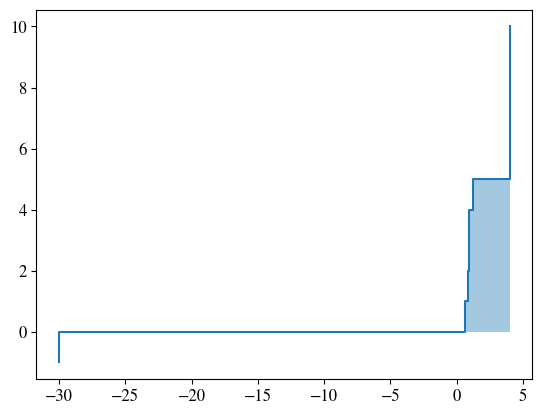

In [46]:
import matplotlib.pyplot as plt
import numpy as np
x=[-30, 0.6532268517612465, 0.8295545887394766, 0.9370065643508667, 0.9392638372023825, 1.2357190050351434, 3.999952187488269, 3.999981126883803, 3.999981126883803, 3.999981126883803, 3.999981126883803, 4]
y=[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


#y2 = np.random.exponential(1, len(x))

plt.fill_between(x,y, step="pre", alpha=0.4)
# plt.fill_between(x,y2, step="pre", alpha=0.4)

plt.plot(x,y, drawstyle="steps")
# plt.plot(x,y2, drawstyle="steps")

plt.show()

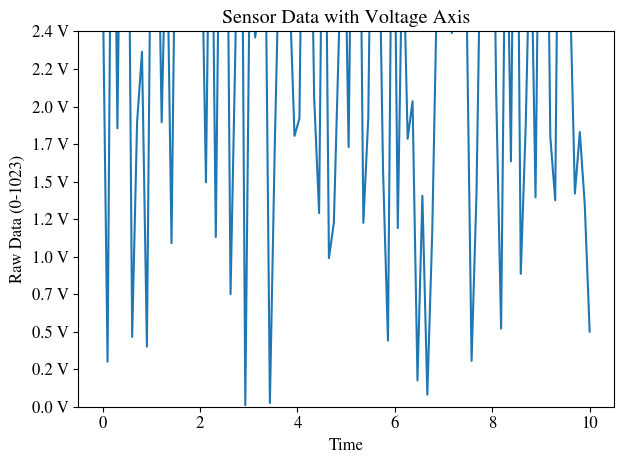

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
x = np.linspace(0, 10, 100)
y = np.random.randint(0, 1024, size=100)

fig, ax = plt.subplots()

# Plot the original data
ax.plot(x, y, label='Sensor Data')
ax.set_xlabel('Time')
ax.set_ylabel('Raw Data (0-1023)')



# Set the y-axis limits to reflect the voltage range
ax.set_ylim(0, 500)

# Define the transformation function
def raw_to_voltage(raw):
    return raw * (5.0 / 1023)

# Set custom ticks for the y-axis
raw_ticks = np.linspace(0, 500, 11)  # 11 ticks from 0 to 1023
voltage_ticks = raw_to_voltage(raw_ticks)
ax.set_yticks(raw_ticks)
ax.set_yticklabels([f'{tick:.1f} V' for tick in voltage_ticks])

plt.title('Sensor Data with Voltage Axis')
fig.tight_layout()
plt.show()



[-30, 3.999981126883803, 0.17378788597782346, 3.999981126883803, 0.31087380261427455, 3.999952187488269, -0.01345000311608402, 3.999981126883803, 0.2876644073973793, 3.999981126883803, -1.28004052737775, 4]


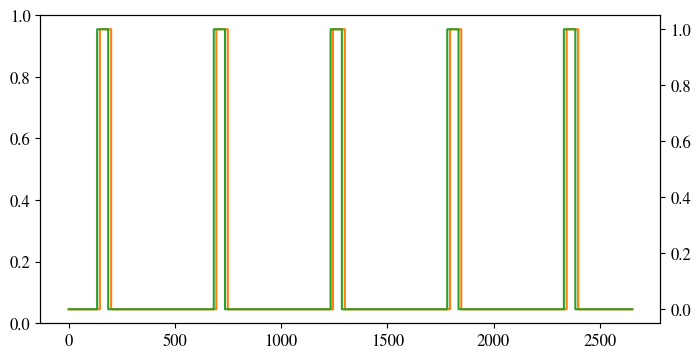

In [5]:
fig, ax = plt.subplots(figsize=(8,4))
ax2 = ax.twinx()

batch = find_batches(list(pd_all.laser_pt), list(pd_all.position))
print(batch)

ax2.step(pd_all.index, pd_all.laser_pt, color = 'C1', label = "reed laser")
ax2.step(pd_all.index, pd_all.laser_reed, color = 'C2', label = "reed laser")

plt.show()